Processing file: input/sinDataComplex.txt
{'file_name': 'sinDataComplex.txt', 'contains_Complex': True, 'contains_LUT': False, 'OSR': 1.0, 'fs': 10000.0, 'complex': 1.0}
1
1
Saved spectrum plot to ./figs/sinDataComplex_spectrum.png


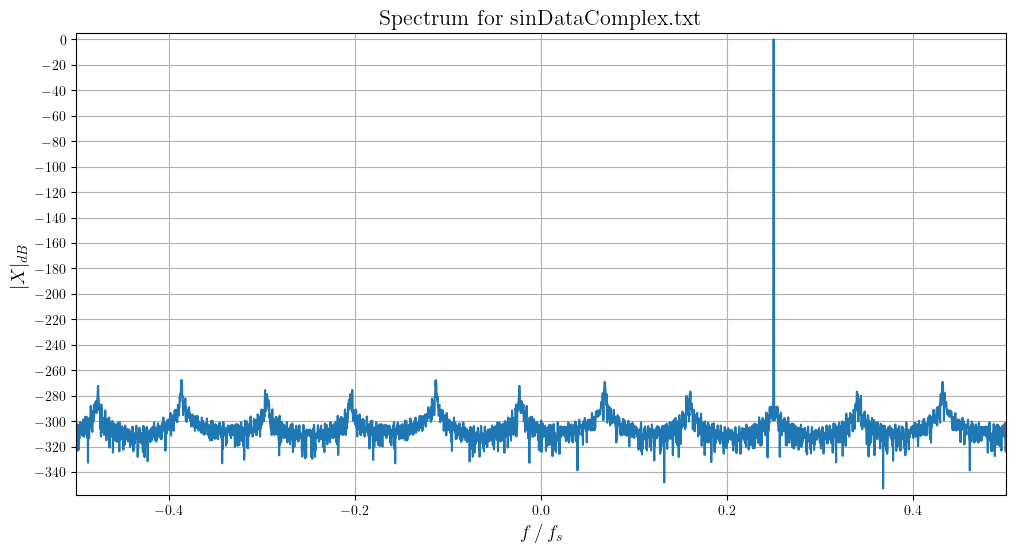

Processed complex data from input/sinDataComplex.txt
Processing file: output/sinDataR_delay_5.txt
{'file_name': 'sinDataR_delay_5.txt', 'contains_Complex': False, 'contains_LUT': False, 'complex': 0.0, 'fs': 10000.0, 'OSR': 1.0}
1
1
Saved spectrum plot to ./figs/sinDataR_delay_5_spectrum.png


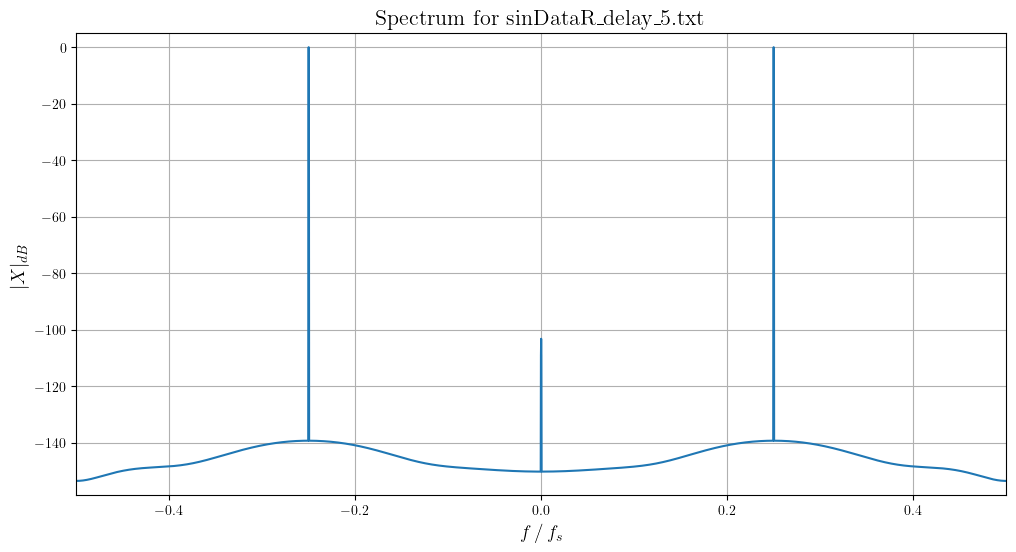

Processed real data from output/sinDataR_delay_5.txt
Processing file: output/sinDataI_delay_25.txt
{'file_name': 'sinDataI_delay_25.txt', 'contains_Complex': False, 'contains_LUT': False, 'complex': 0.0, 'fs': 10000.0, 'OSR': 1.0}
1
1
Saved spectrum plot to ./figs/sinDataI_delay_25_spectrum.png


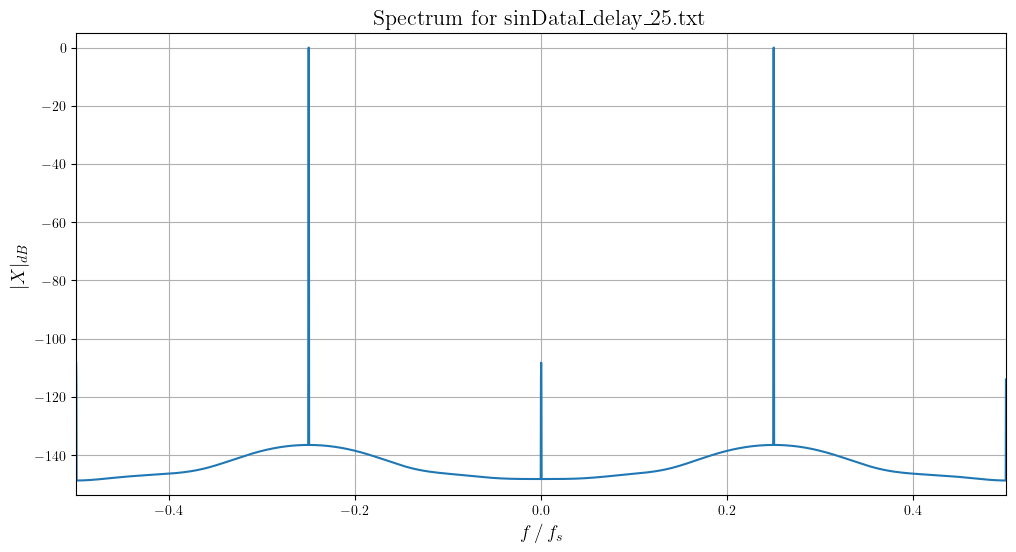

Processed real data from output/sinDataI_delay_25.txt
Processing file: output/sinDataR_OSR_8.txt
{'file_name': 'sinDataR_OSR_8.txt', 'contains_Complex': False, 'contains_LUT': False, 'complex': 0.0, 'fs': 10000.0, 'OSR': 8.0}
1
1
Saved spectrum plot to ./figs/sinDataR_OSR_8_spectrum.png


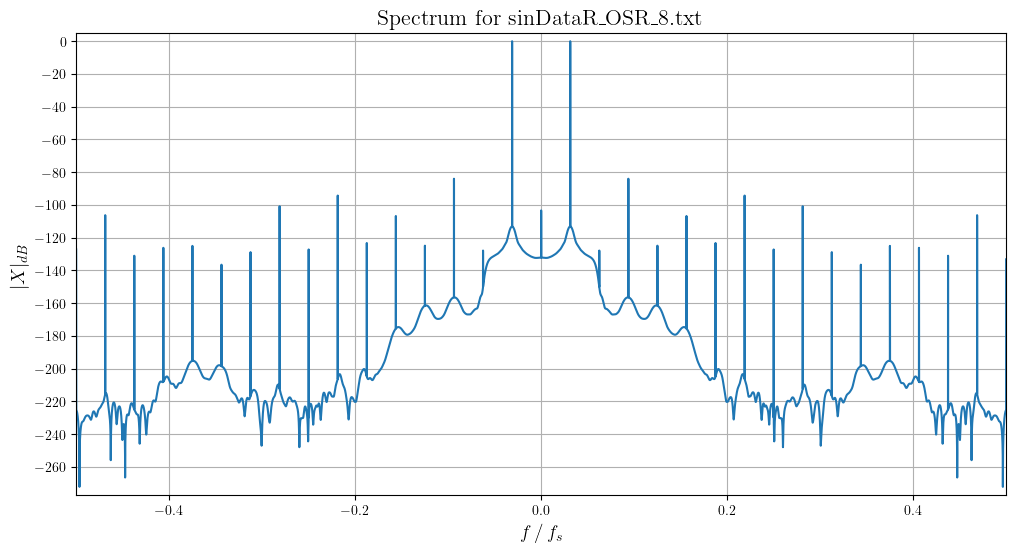

Processed real data from output/sinDataR_OSR_8.txt
Processing file: output/sinDataI_OSR_8.txt
{'file_name': 'sinDataI_OSR_8.txt', 'contains_Complex': False, 'contains_LUT': False, 'complex': 0.0, 'fs': 10000.0, 'OSR': 8.0}
1
1
Saved spectrum plot to ./figs/sinDataI_OSR_8_spectrum.png


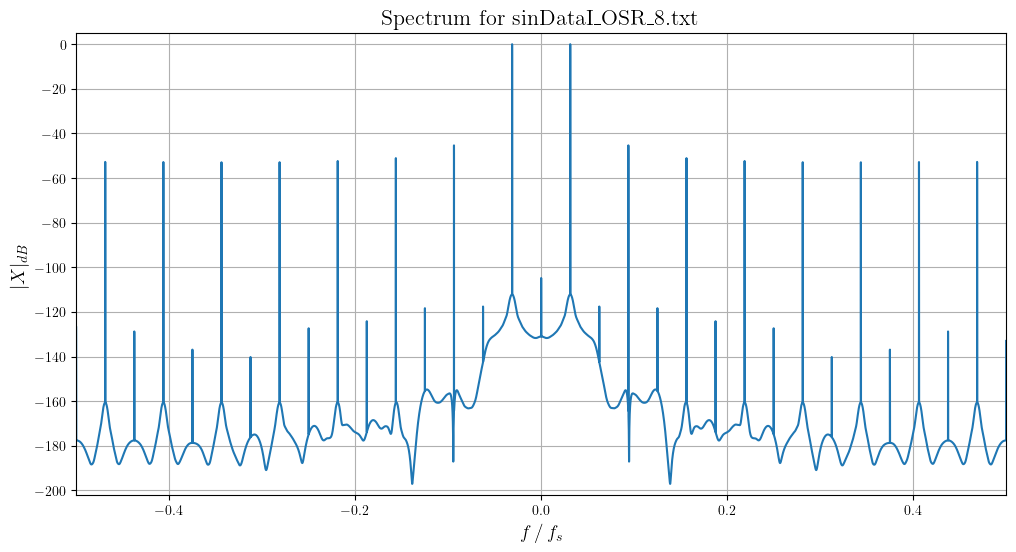

Processed real data from output/sinDataI_OSR_8.txt
Processing file: output/sinDataR_deltaSigma.txt
{'file_name': 'sinDataR_deltaSigma.txt', 'contains_Complex': False, 'contains_LUT': False, 'complex': 0.0, 'fs': 10000.0, 'OSR': 8.0}
1
1
Saved spectrum plot to ./figs/sinDataR_deltaSigma_spectrum.png


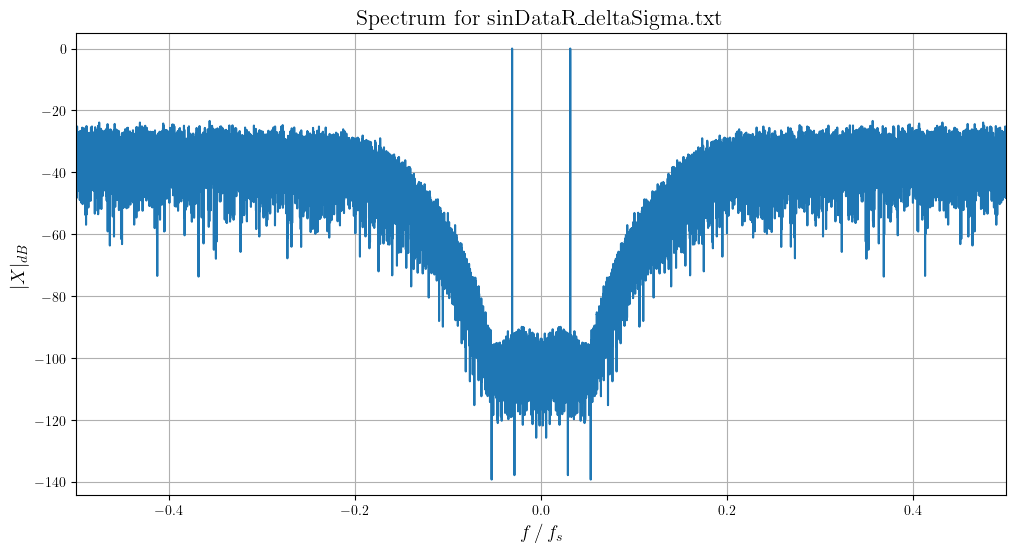

Processed real data from output/sinDataR_deltaSigma.txt
Processing file: output/sinDataI_deltaSigma.txt
{'file_name': 'sinDataI_deltaSigma.txt', 'contains_Complex': False, 'contains_LUT': False, 'complex': 0.0, 'fs': 10000.0, 'OSR': 8.0}
1
1
Saved spectrum plot to ./figs/sinDataI_deltaSigma_spectrum.png


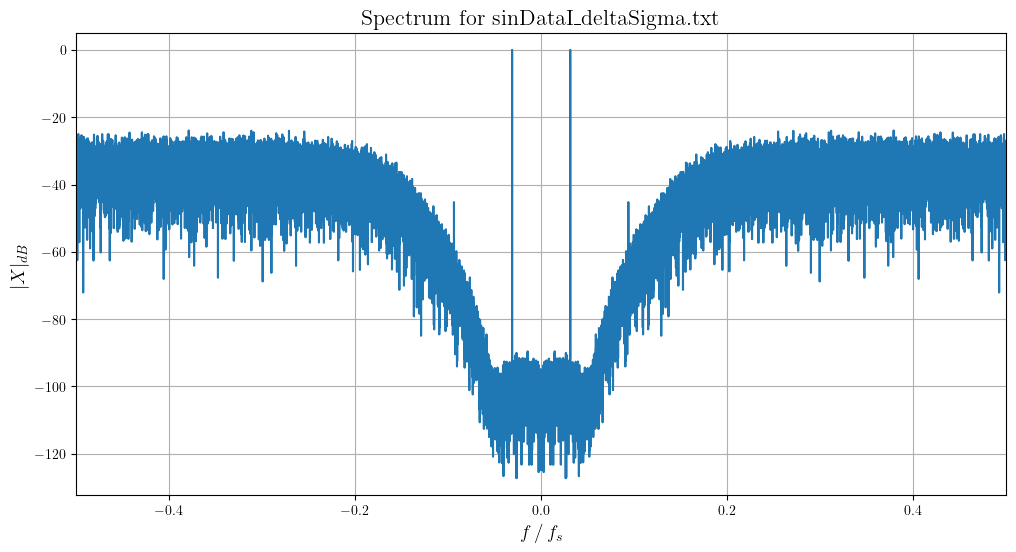

Processed real data from output/sinDataI_deltaSigma.txt
Processing file: output/sinData_deltaSigma_double.txt
{'file_name': 'sinData_deltaSigma_double.txt', 'contains_Complex': False, 'contains_LUT': False, 'complex': 0.0, 'fs': 10000.0, 'OSR': 8.0}
1
1
Saved spectrum plot to ./figs/sinData_deltaSigma_double_spectrum.png


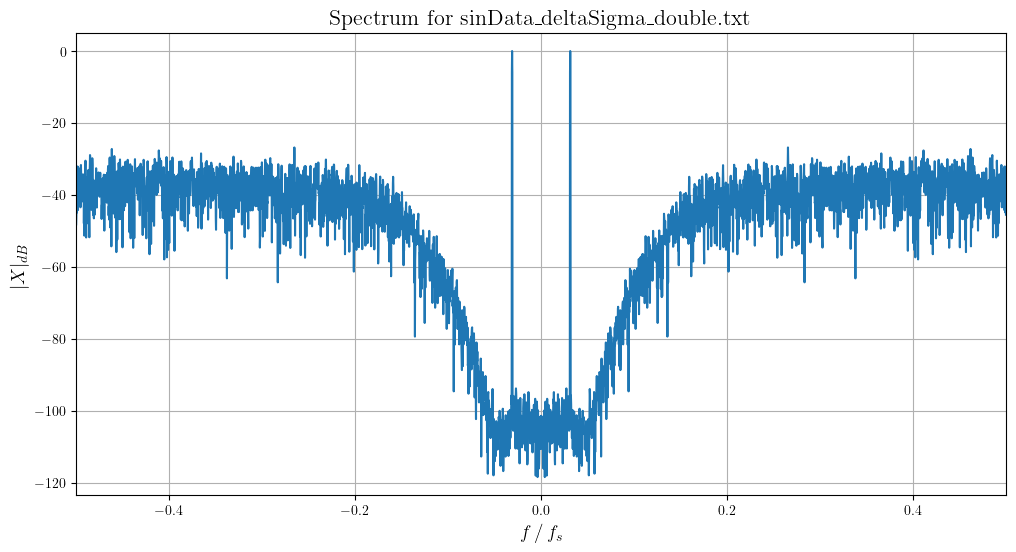

Processed real data from output/sinData_deltaSigma_double.txt


In [26]:
#!/usr/bin/env python3

import os
import sys
import numpy as np
import scipy.signal as signal
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def read_file_with_header(file_path):
    """
    Reads a file with metadata in the header and numerical data below.
    Checks the filename for specific keywords like 'Complex' or 'LUT'.
    
    Args:
        file_path (str): Path to the input file.
    
    Returns:
        dict: Metadata key-value pairs, including file name details.
        np.ndarray: Numerical data as a NumPy array.
    """
    metadata = {}
    data = []

    # Extract the filename
    file_name = os.path.basename(file_path)
    metadata['file_name'] = file_name  # Store the filename in metadata

    # Check if the filename contains specific keywords
    metadata['contains_Complex'] = 'Complex' in file_name
    metadata['contains_LUT'] = 'LUT' in file_name

    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                key_value = line[1:].strip().split("=")  # Metadata in format `key=value`
                if len(key_value) == 2:
                    key, value = key_value[0].strip(), key_value[1].strip()
                    try:
                        # Convert numeric metadata to float if possible
                        metadata[key] = float(value) if value.replace('.', '', 1).isdigit() else value
                    except ValueError:
                        metadata[key] = value
            else:
                try:
                    # Read data based on metadata
                    if metadata.get('complex', 0) == 1:  # If complex metadata is 1
                        real, imag = map(float, line.strip().split())
                        data.append(complex(real, imag))
                    else:  # If complex metadata is 0
                        data.append(float(line.strip()))
                except ValueError:
                    pass  # Ignore non-numeric lines

    return metadata, np.array(data)

def process_file(file_path):
    """
    Processes a single file, extracting metadata, computing the spectrum, and saving plots.
    
    Args:
        file_path (str): Path to the file.
    """
    print(f"Processing file: {file_path}")
    metadata, data = read_file_with_header(file_path)
    print(metadata)

    if not data.size:
        print(f"Warning: No valid numerical data found in {file_path}")
        return

    # Extract metadata
    OSR = int(metadata.get("OSR", 1))
    is_complex = metadata.get("complex", 0) == 1  # Check if the data is complex
    lut_width = metadata.get("lut_width", 1)

    # Compute the windowed data and spectrum
    print(lut_width)
    w = signal.windows.hann(len(data), False)
    data_win = data * w
    spectrum = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(data_win))))
    spectrum -= np.max(spectrum)
    freqs = (np.arange(len(data)) / len(data) - 0.5)

    # Plot the spectrum
    plt.figure(figsize=(12, 6))
    plt.plot(freqs, spectrum, label="Spectrum")
    plt.title(f"Spectrum for {os.path.basename(file_path)}", fontsize=16)
    plt.xlabel(r"$f \, / \, f_s$", fontsize=14)
    plt.ylabel(r"$|X|_{dB}$", fontsize=14)

    print(lut_width)
    x_min = -0.5/lut_width
    x_max = 0.5/lut_width
    y_min = np.min(spectrum[int((x_min+0.5)*len(spectrum)):int((x_max+0.5)*len(spectrum))])
    y_max = np.max(spectrum[int((x_min+0.5)*len(spectrum)):int((x_max+0.5)*len(spectrum))])

    y_ticks = np.arange(y_max, y_min - 20, -20)  # Generate ticks from 0 to y_max with step of 20
    plt.yticks(y_ticks)

    plt.xlim([x_min, x_max])
    plt.ylim(y_min - 5, y_max + 5)

    plt.grid()

    # Save the figure
    file_name = os.path.basename(file_path).replace('.txt', '_spectrum.png')
    fig_path = os.path.join("./figs", file_name)
    plt.savefig(fig_path)
    print(f"Saved spectrum plot to {fig_path}")
    # plt.close()
    plt.show();

    # Additional printout for complex vs real
    data_type = "complex" if is_complex else "real"
    print(f"Processed {data_type} data from {file_path}")

def main():
    file_path = "input/sinDataComplex.txt"
    process_file(file_path)
    file_path = "output/sinDataR_delay_5.txt"
    process_file(file_path)
    file_path = "output/sinDataI_delay_25.txt"
    process_file(file_path)
    file_path = "output/sinDataR_OSR_8.txt"
    process_file(file_path)
    file_path = "output/sinDataI_OSR_8.txt"
    process_file(file_path)
    file_path = "output/sinDataR_deltaSigma.txt"
    process_file(file_path)
    file_path = "output/sinDataI_deltaSigma.txt"
    process_file(file_path)

    file_path = "output/sinData_deltaSigma_double.txt"
    process_file(file_path)

if __name__ == "__main__":
    main()


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from remezlp import remezlp

In [6]:
def genTestSpectrum(n, freq, amp, randPhase=False):
    # Generate test spectrum
    # Arguments:
    #    n    - number of samples
    #    freq - tuple of digital frequencies (startFreq, endFreq) in range (0, 0.5)
    #    amp  - tuple of amplitudes (ampStart, ampEnd)
    #    randPhase - if True, assign random phase to each sample
    x = np.zeros(n, dtype='complex128')
    freqStart, freqEnd = freq
    ampStart, ampEnd = amp
    indStart = round(n*freqStart)
    indEnd = round(n*freqEnd)
    x[indStart:indEnd] = ampStart - np.linspace(0, 1, num=indEnd-indStart) * (ampStart-ampEnd)
    if randPhase:
        x[indStart:indEnd] *= np.exp(1j*2*np.pi*np.random.rand(indEnd-indStart)) # randomize phase
    x[0] = abs(x[1])/2
    timeDomain = np.fft.ifft(x)
    return(timeDomain)
    
def expander(x, I):
    # Upsample the signal by factor I
    #   x - input signal
    #   I - upsampling factor
    nx = len(x)
    xI = np.zeros(nx*I, dtype=complex)
    xI[::I] = x
    return xI

def compressor(x, D):
    # Downsample the signal by factor D
    #   x - input signal
    #   D - downsampling factor
    return x[0::D]

def plotdB(x, win=False, epsilon=1e-12):
    if win==True:
        w = signal.windows.hamming(len(x), False)
        x *= w
    x += epsilon
    XdB = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x)) + epsilon))
    XdB -= np.max(XdB)
    freqs = np.arange(len(x))/len(x) - 0.5

    plt.plot(freqs, XdB)
    plt.grid()
    # plt.show();

def plot(x, win=False, epsilon=1e-15):
    if win==True:
        w = signal.hann(len(x), False)
        x *= w
    Xfft = np.abs(np.fft.fftshift(np.fft.fft(x)))
    Xfft /= np.max(Xfft)
    freqs = np.arange(len(x))/len(x) - 0.5
    plt.plot(freqs, Xfft)
    plt.grid()
    

def makePolyphase(coeff, M):
    # Split coefficients into polyphase components
    n = int(np.ceil(len(coeff)/M))
    tmp = np.zeros(n*M)
    tmp[:len(coeff)] = coeff
    polyCoeff = np.zeros((M,n))
    for i in range(M):
        polyCoeff[i,:] = tmp[i::M]
    return polyCoeff

def polyI(x, firCoeff, I):
    polyFIR = makePolyphase(firCoeff, I)
    xPoly = np.zeros(len(x)*I, dtype=type(x))
    for i in range(I):
        tmp = signal.lfilter(polyFIR[i], 1.0, np.concatenate((x, x[:int(len(firCoeff)/I-1)])))
        tmp = tmp[int(len(firCoeff)/I-1):]
        xPoly[i::I] = tmp
    return xPoly

def polyD(x, firCoeff, D):
    polyFIR = makePolyphase(firCoeff, I)
    x_ = np.concatenate((x, x[:int(len(firCoeff)-1)]))
    y = []
    for i in range(D):
        FIRin = x_[i::D]
        tmp = signal.lfilter(polyFIR[D-1-i], 1.0, FIRin)
        y = np.append(y, tmp)
    y = np.array(y)
    return y

def fftdB(x, epsilon=1e-12):
    return 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(x)) + epsilon))

Fmax = 0.425


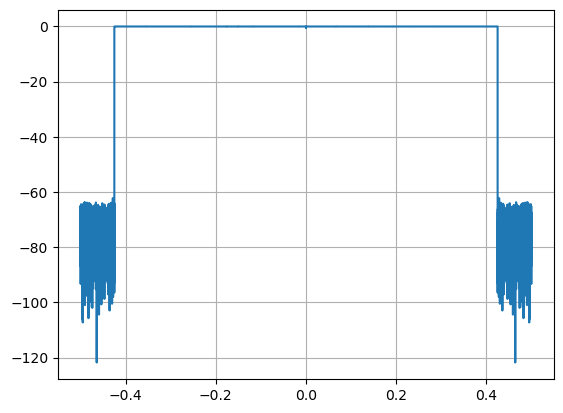

In [7]:
I = 8
N = 2**16
n = np.arange(N)

perc = 0.15
Fmax = 0.5 * (1 - perc)
print(f"Fmax = {Fmax}")

AdB = 60
deltaPass = 10**(-AdB/20)
deltaStop = deltaPass

F = [0.0, Fmax]
A = [1.0, 1.0]
x = 2*genTestSpectrum(N, F, A, True).real
amp = 1e-6
x += np.random.normal(-amp, amp, len(x))
plotdB(x, False)

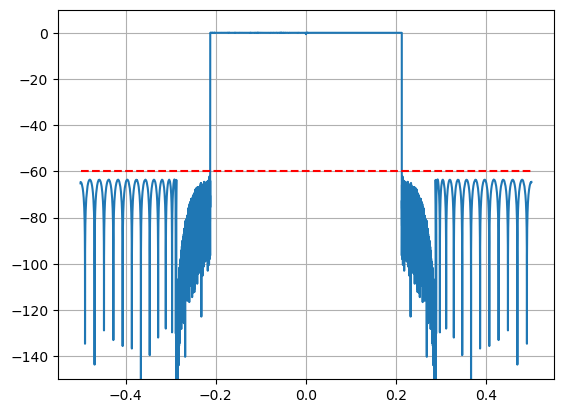

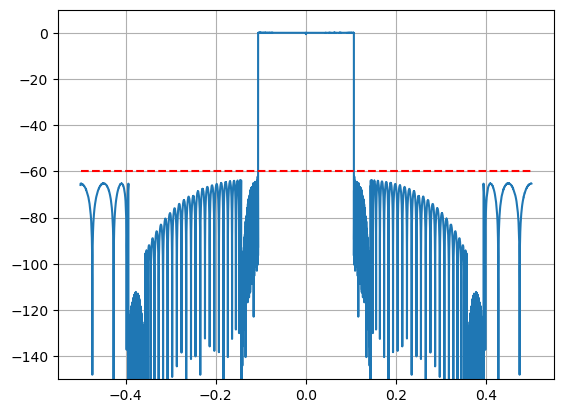

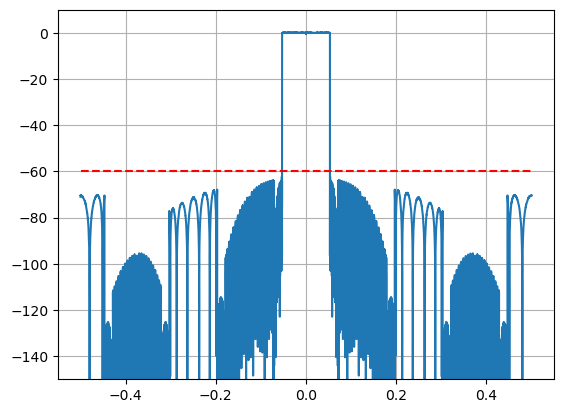

Fpass = [0.2125, 0.10625, 0.053125]
Fstop = [0.2875, 0.39375, 0.446875]
dF = [0.07499999999999998, 0.2875, 0.39375000000000004]
N_fir = [47, 11, 7]
[array([-8.29782898e-04, -3.14502611e-06,  1.50946649e-03,  1.88127428e-06,
       -2.79362858e-03, -6.46521600e-06,  4.72907470e-03,  5.28063189e-06,
       -7.51482450e-03, -1.01561872e-05,  1.14516105e-02,  9.67228666e-06,
       -1.69746701e-02, -1.47693676e-05,  2.48898199e-02,  1.37836841e-05,
       -3.68574681e-02, -1.83196893e-05,  5.72484127e-02,  1.66721530e-05,
       -1.02143985e-01, -2.03872314e-05,  3.16973544e-01,  5.00017764e-01,
        3.16973544e-01, -2.03872314e-05, -1.02143985e-01,  1.66721530e-05,
        5.72484127e-02, -1.83196893e-05, -3.68574681e-02,  1.37836841e-05,
        2.48898199e-02, -1.47693676e-05, -1.69746701e-02,  9.67228666e-06,
        1.14516105e-02, -1.01561872e-05, -7.51482450e-03,  5.28063189e-06,
        4.72907470e-03, -6.46521600e-06, -2.79362858e-03,  1.88127428e-06,
        1.50946649e-03, -3

In [8]:
Fpass_, Fstop_ = Fmax, 1-Fmax
xI = x

Fpass_arr, Fstop_arr, dF = [], [], []
N_fir = []
firCoeffs = []

iterator = int(np.log(I)/np.log(2))
for i in range(iterator):
    Fstop_ = (1-Fpass_)/2
    Fpass_ /= 2 
    Fpass_arr.append(Fpass_)
    Fstop_arr.append(Fstop_)
    dF.append(Fstop_ - Fpass_)
    
    firCoeff = remezlp(Fpass_, Fstop_, deltaPass, deltaStop, nPoints=N, Nmax=N)
    # firCoeff = firCoeff[1:-1]
    firCoeffs.append(firCoeff)
    N_fir.append(firCoeff.size)

    xI = expander(xI, 2)
    xI = signal.lfilter(firCoeff, 1.0, np.concatenate((xI, xI[:len(firCoeff)-1])))[len(firCoeff)-1:]

    plotdB(xI)
    plt.plot([-0.5,0.5], [-AdB, -AdB], '--r')
    plt.ylim([-150, 10])
    plt.show();

print(f"Fpass = {Fpass_arr}")
print(f"Fstop = {Fstop_arr}")
print(f"dF = {dF}")
print(f"N_fir = {N_fir}")
print(firCoeffs)

<StemContainer object of 3 artists>

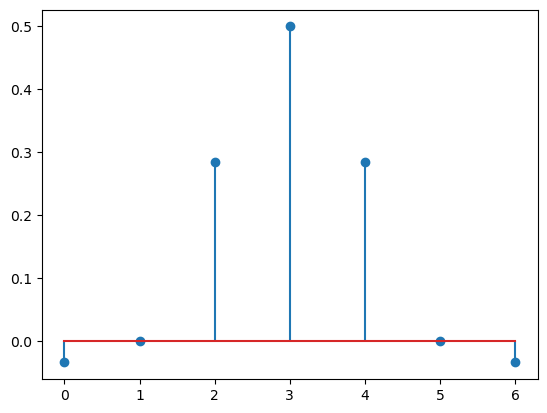

In [10]:
plt.stem(firCoeffs[2])

In [21]:
print((np.array(Fpass_arr) + np.array(Fstop_arr))/2)

[0.25 0.25 0.25]


In [ ]:
def H0_fir(sample):
    global h0_buffer, h0_index
    ho_buffer[h0_index] = sample
    y = h0_buffer[h0]

def polyInt_hb(inSignal, firCoeffs):
    for n in range(len(inSignal)):
        